<a href="https://colab.research.google.com/github/talexie/pilotai/blob/main/AI_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install tensorflow  recordlinkage['all']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 5.3 MB/s eta 0:00:00


number of channels = 2
length = 0.01s


<ipython-input-31-02eb30f118fe>:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(wav_data, dtype='int16')[-16000:]


number of channels = (16000, 1)
length = 0.7256235827664399s
[[0.5 0.5]
 [0.4 0.6]]
[[0.22557992 0.14172435 0.0995599  0.08246648 0.08900827 0.09782773
  0.11637747 0.15879065 0.15290713 0.10642171 0.07418841 0.05446672
  0.05499524 0.07721573 0.11640877 0.160384   0.1885227  0.21342498
  0.21139461 0.19533944 0.2037422  0.22636586 0.27143532 0.29951745
  0.17240483 0.09821188 0.06726509 0.05782139 0.07934618 0.13382572
  0.20342726 0.24540085 0.28605753 0.27937305 0.26941776 0.2792554
  0.30859733 0.29949445 0.19619685 0.12755245 0.07941294 0.05790144
  0.07562256 0.11657298 0.20322877 0.24504036 0.23386127 0.18626863
  0.13534808 0.14560008 0.12699729 0.12807924 0.15231955 0.17440838
  0.2158109  0.27354234 0.33623517 0.43460763 0.48399287 0.25713342
  0.17415017 0.16882974 0.15344495 0.19861054 0.27945882 0.27131325
  0.28638357 0.31745416 0.31924272 0.3316443  0.35461712 0.36199337
  0.35072583 0.31771964 0.29938602 0.29216415 0.30131018 0.32971174
  0.36052036 0.4044851  0.4526817

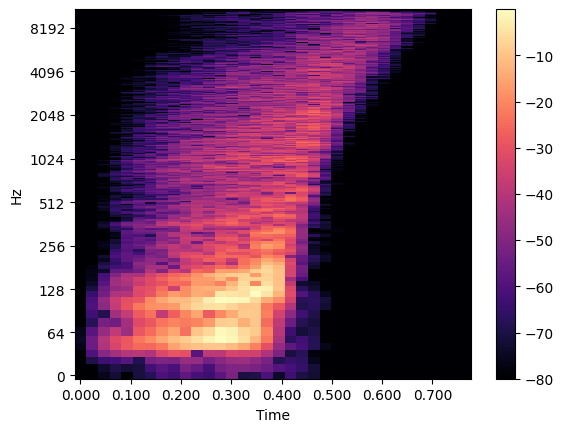

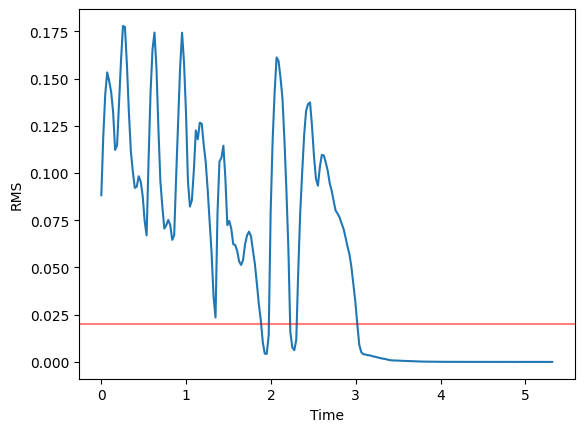

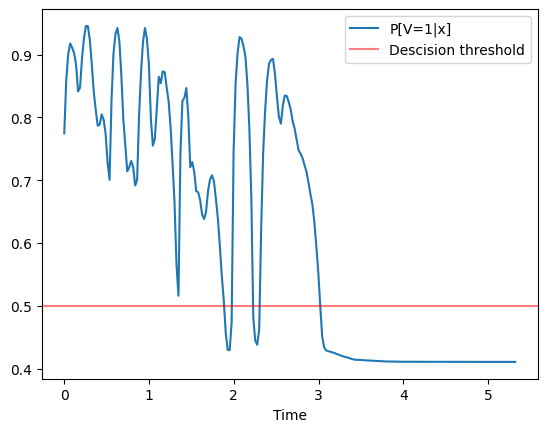

<Figure size 1200x600 with 0 Axes>

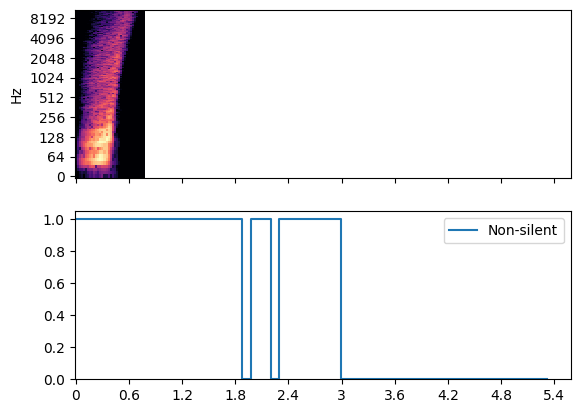

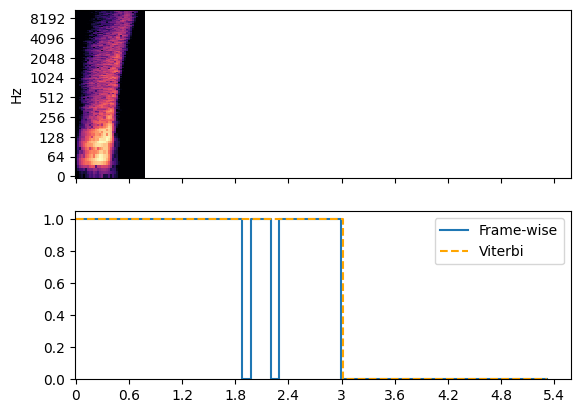

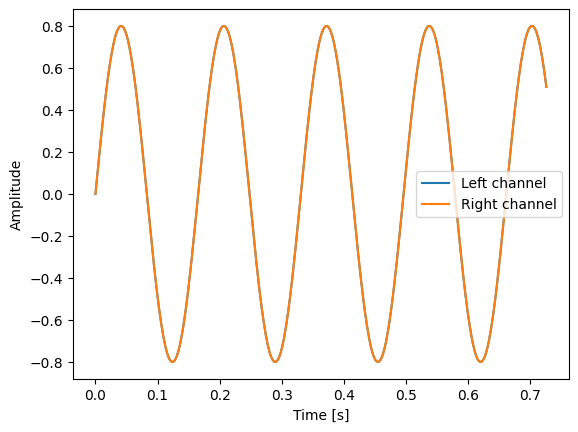

In [31]:
import numpy as np
import tensorflow as tf
import soundfile as sf
import io
import librosa as lbs

from six.moves.urllib.request import urlopen
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
import pathlib
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

data_dir = pjoin(dirname(scipy.io.__file__), 'tests', 'data')
wav_fname = pjoin(data_dir, 'test-44100Hz-2ch-32bit-float-be.wav')
tsamplerate, tdata = wavfile.read(wav_fname)
print(f"number of channels = {tdata.shape[1]}")
tlength = tdata.shape[0] / tsamplerate
print(f"length = {tlength}s")

url = "https://github.com/talexie/pilotai/blob/bff954e2146d310dcf3fc3b3810684f3ae736b15/mixkit-fast-small-sweep-transition-166.wav"
z = io.BytesIO(urlopen(url).read())

wav_data, samplerate = lbs.load('/home/test/mixkit-fast-small-sweep-transition-166.wav')
data = np.fromstring(wav_data, dtype='int16')[-16000:]

# Normalize the data
data = data * 1.0 / (1 << 15)   # Range [-1 1]
data = np.float32(data)
data = tf.reshape(data, (16000, 1))
print(f"number of channels = {data.shape}")
length = data.shape[0] / samplerate
print(f"length = {length}s")

# tf.cast(data, tf.float32)
stfts = tf.signal.stft(data, frame_length=1024,
                                frame_step=256,fft_length=1024)
S_full, phase = lbs.magphase(lbs.stft(wav_data))


y, sr = lbs.load(lbs.ex('trumpet'))


# And compute the spectrogram magnitude and phase
#S_full, phase = lbs.magphase(lbs.stft(y))


###################
# Plot the spectrum
fig, ax = plt.subplots()
img = lbs.display.specshow(lbs.amplitude_to_db(S_full, ref=np.max),
                               y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax);
# As a first step, we can plot the root-mean-square (RMS) curve
rms = lbs.feature.rms(y=y)[0]

times = lbs.frames_to_time(np.arange(len(rms)))

fig, ax = plt.subplots()
ax.plot(times, rms)
ax.axhline(0.02, color='r', alpha=0.5)
ax.set(xlabel='Time', ylabel='RMS');

r_normalized = (rms - 0.02) / np.std(rms)
p = np.exp(r_normalized) / (1 + np.exp(r_normalized))

fig, ax = plt.subplots()
ax.plot(times, p, label='P[V=1|x]')
ax.axhline(0.5, color='r', alpha=0.5, label='Descision threshold')
ax.set(xlabel='Time')
ax.legend();

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(nrows=2, sharex=True)
lbs.display.specshow(lbs.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].label_outer()
ax[1].step(times, p>=0.5, label='Non-silent')
ax[1].set(ylim=[0, 1.05])
ax[1].legend()

transition = lbs.sequence.transition_loop(2, [0.5, 0.6])
print(transition)

full_p = np.vstack([1 - p, p])
print(full_p)

states = lbs.sequence.viterbi_discriminative(full_p, transition)

# sphinx_gallery_thumbnail_number = 5
fig, ax = plt.subplots(nrows=2, sharex=True)
lbs.display.specshow(lbs.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].label_outer()
ax[1].step(times, p>=0.5, label='Frame-wise')
ax[1].step(times, states, linestyle='--', color='orange', label='Viterbi')
ax[1].set(ylim=[0, 1.05])
ax[1].legend()

#t = np.linspace(0., length, stfts.shape[0])
t = np.arange(length)
#sp = fftshift(fft(np.sin(t)))
#freq = fftshift(fftfreq(t.shape[-1]))
print(f'shapes:{ t.shape} XXX: {stfts.shape[0]}')
plt.plot(t, stfts.shape[0], label="FFT" )
plt.show()


#time = np.linspace(0., length, data.shape[0])
#plt.plot(time, data[:, 0], label="Left channel")
#plt.plot(time, data[:, 1], label="Right channel")

time = np.linspace(0., length, tdata.shape[0])
plt.plot(time, tdata[:, 0], label="Left channel")
plt.plot(time, tdata[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
